###

### Quickstart: Compare runs, choose a model, and deploy it to a REST API

* Run a hyperparameter sweep on training script
* Compare the results of the runs in the MLFlow UI
* Choose the best run and register it as a model
* Deploy the model to a REST API
* Build a container image suitable for deployment to a cloud platform

In [1]:
import keras
import numpy as np
import pandas as pd
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature

#### load the dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-white.csv",
                 sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


quality is dependent feature

#### Split data

In [3]:
train, test = train_test_split(df, test_size = .25, random_state=42)
train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2835,6.3,0.25,0.22,3.30,0.048,41.0,161.0,0.99256,3.16,0.50,10.5,6
1157,7.8,0.30,0.29,16.85,0.054,23.0,135.0,0.99980,3.16,0.38,9.0,6
744,7.4,0.38,0.27,7.50,0.041,24.0,160.0,0.99535,3.17,0.43,10.0,5
1448,7.4,0.16,0.49,1.20,0.055,18.0,150.0,0.99170,3.23,0.47,11.2,6
3338,7.2,0.27,0.28,15.20,0.046,6.0,41.0,0.99665,3.17,0.39,10.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4426,6.2,0.21,0.52,6.50,0.047,28.0,123.0,0.99418,3.22,0.49,9.9,6
466,7.0,0.14,0.32,9.00,0.039,54.0,141.0,0.99560,3.22,0.43,9.4,6
3092,7.6,0.27,0.52,3.20,0.043,28.0,152.0,0.99129,3.02,0.53,11.4,6
3772,6.3,0.24,0.29,13.70,0.035,53.0,134.0,0.99567,3.17,0.38,10.6,6


In [4]:
train_x = train.drop(['quality'],axis=1).values
train_y = train[['quality']].values.ravel()

## test dataset
test_x = test.drop(['quality'],axis=1).values
test_y = test['quality'].values.ravel()

## splitting this train data into train and validation
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [5]:
train_y

array([4, 4, 5, ..., 6, 6, 6])

In [6]:
train_x

array([[ 5.8 ,  0.28,  0.35, ...,  3.28,  0.5 , 10.2 ],
       [ 7.1 ,  0.21,  0.28, ...,  3.35,  0.64, 10.2 ],
       [ 5.9 ,  0.32,  0.26, ...,  3.24,  0.36, 10.7 ],
       ...,
       [ 7.4 ,  0.2 ,  0.37, ...,  3.14,  0.61, 11.8 ],
       [ 8.1 ,  0.3 ,  0.31, ...,  2.99,  0.45, 11.1 ],
       [ 6.6 ,  0.36,  0.21, ...,  3.18,  0.41,  9.9 ]])

#### infer signature

In [7]:
signature = infer_signature(train_x, train_y)

#### ANN model

In [8]:
def train_model(params, 
                epochs, 
                train_x, 
                train_y, 
                valid_x, 
                valid_y, 
                test_x, 
                test_y):
    
    # define model architecture
    mean=np.mean(train_x, axis=0) # its required for normalization
    var=np.var(train_x, axis=0) # its required for normalization

    model=keras.Sequential(
        [
            keras.Input([train_x.shape[1]]),
            keras.layers.Normalization(mean=mean,variance=var),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1)
        ]
    )

    ## compile the model
    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=params['lr'], 
        momentum=params['momentum'] #params['lr'] will cause that model will try different lr to find best learning rate, same for momentum 
        ),
        loss='mean_squared_error',
        metrics=[keras.metrics.RootMeanSquaredError()]
        )
    
    ## train the ANN model with lr and momentum params and track both in MLFlow tracking
    with mlflow.start_run(nested=True):
        model.fit(train_x,
                  train_y,
                  validation_data=(valid_x,valid_y),
                  epochs=epochs,
                  batch_size=64)
        
        ## evaluate the model
        eval_result=model.evaluate(valid_x, valid_y, batch_size=64)
        eval_rmse=eval_result[1]
        try:
            ## log the parameters and results
            mlflow.log_params(params)
            mlflow.log_metric('eval_rmse', eval_rmse)

            ## log the model
            mlflow.tensorflow.log_model(model,'model',signature=signature)

            return {'loss':eval_rmse, 'status':STATUS_OK, 'model':model}
        except Exception as e:
            print('MlFlow log error: {e}')


#### Hyperparameter Tuning

Objective function is required from hyperopt

In [9]:
def objective(params):
    #MLflow will track the parameters and results for each run
    result = train_model(
        params,
        epochs=3,
        train_x=train_x,
        train_y=train_y,
        valid_x=valid_x,
        valid_y=valid_y,
        test_x=test_x,
        test_y=test_y
    )
    return result

Setting hyperparameters for tuning

In [10]:
space={
    'lr':hp.loguniform('lr',np.log(1e-5),np.log(1e-1)),
    'momentum':hp.uniform('momentum',0.0,1.0)
}

In [11]:
mlflow.set_experiment('/wine-quality')
with mlflow.start_run():
    # conduct the hyperparameter search using Hyperopt
    trials=Trials()
    best=fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=4, 
        trials=trials
    )

# fetch the details of the best run
best_run = sorted(trials.results, key=lambda x: x['loss'])[0]

# print out the best parameters and corresponding loss
print(f'Best parameters: {best}')
print(f'Best eval rmse: {best_run['loss']}')

  0%|          | 0/4 [00:00<?, ?trial/s, best loss=?]

Epoch 1/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 33.6257 - root_mean_squared_error: 5.7988
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0968 - root_mean_squared_error: 2.0856 - val_loss: 0.8460 - val_root_mean_squared_error: 0.9198

Epoch 2/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6780 - root_mean_squared_error: 0.8234
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6322 - root_mean_squared_error: 0.7950 - val_loss: 0.5787 - val_root_mean_squared_error: 0.7607

Epoch 3/3                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7127 - root_mean_squared_error: 0.8442
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5807 - root_mean_squared_error: 0.7619 - val_loss: 0.5666 - val_root_mean_squared_error: 0.7527

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4709 - root_mean_squared_error: 0.6862
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

#### Validation

In [29]:
## Inferencing

from mlflow.models import validate_serving_input

model_uri = 'runs:/fe839326b44946818dc1f9e37184b956/model'

from mlflow.models import convert_input_example_to_serving_input

serving_payload = convert_input_example_to_serving_input(test_x)

test_preds = validate_serving_input(model_uri, serving_payload)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


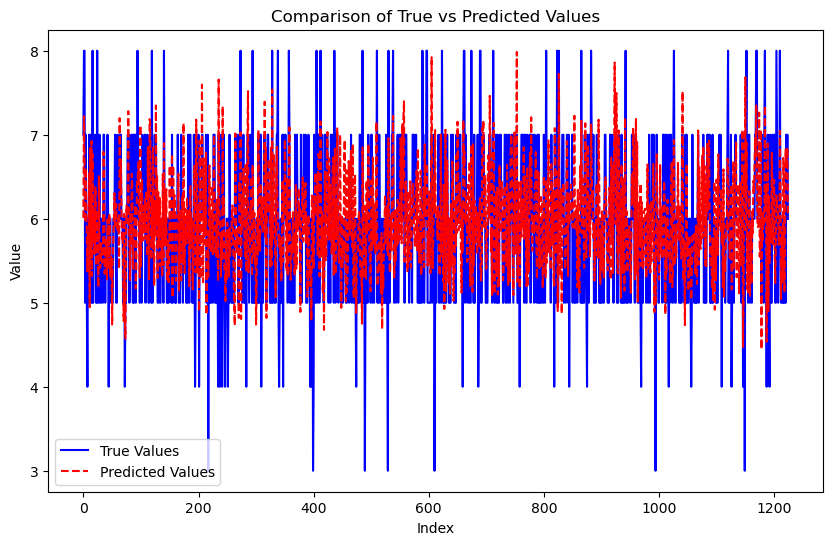

In [30]:
import matplotlib.pyplot as plt

# Plotting the true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='True Values', color='blue')
plt.plot(test_preds, label='Predicted Values', color='red', linestyle='dashed')
plt.legend()
plt.title('Comparison of True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()


Mean Absolute Error

In [31]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_y, test_preds)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.574087655203683


Root Mean Squared Error

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_y, test_preds))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 0.7337063701463852


R-squared

In [33]:
from sklearn.metrics import r2_score

r2 = r2_score(test_y, test_preds)
print(f'R-squared (R²): {r2}')

R-squared (R²): 0.30658531188964844


#### Predictions Dataframe

In [37]:
import mlflow
logged_model = 'runs:/fe839326b44946818dc1f9e37184b956/model'

loaded_model = mlflow.pyfunc.load_model(logged_model)

import pandas as pd
test_pred = loaded_model.predict(pd.DataFrame(test_x))

pred_df = pd.DataFrame(test_x,columns=df.drop(['quality'],axis=1).columns)
pred_df['PREDICTED QUALITY'] = test_preds
pred_df

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,PREDICTED QUALITY
0,6.00,0.29,0.41,10.80,0.048,55.0,149.0,0.99370,3.09,0.59,10.966667,6.008711
1,5.40,0.53,0.16,2.70,0.036,34.0,128.0,0.98856,3.20,0.53,13.200000,7.220656
2,7.10,0.25,0.39,2.10,0.036,30.0,124.0,0.99080,3.28,0.43,12.200000,6.706171
3,7.30,0.28,0.35,1.60,0.054,31.0,148.0,0.99178,3.18,0.47,10.700000,5.957114
4,6.50,0.32,0.34,5.70,0.044,27.0,91.0,0.99184,3.28,0.60,12.000000,6.605950
...,...,...,...,...,...,...,...,...,...,...,...,...
1220,6.15,0.21,0.37,3.20,0.021,20.0,80.0,0.99076,3.39,0.47,12.000000,6.823122
1221,7.10,0.28,0.44,1.80,0.032,32.0,107.0,0.99070,3.25,0.48,12.200000,6.668843
1222,5.90,0.13,0.28,1.90,0.050,20.0,78.0,0.99180,3.43,0.64,10.800000,6.633036
1223,6.80,0.30,0.29,6.20,0.025,29.0,95.0,0.99071,3.03,0.32,12.900000,6.846783
